In [1]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig
import boto3
from rasterio.session import AWSSession
from pathlib import Path
import tempfile
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np
import pandas as pd
from dem_stitcher.rio_tools import rasterize_shapes_to_array, get_cropped_profile
import rasterio.plot as plot

# Get AWS Session

In [2]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')

# Get Metadata for Hansen Tiles in GeoDataFrame

In [3]:
obj = s3.Object('calval-metadata', 'test-prod--hansen-landsat-mosaics-2020.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': '16JNX2AQ7CBFMEVC',
  'HostId': 'jFfckWhq6DtgpWGQMsH/oOmn+nFdG2yHelst+HXTQ/PYECP8rdd4FTzFaH2pmH9qrCgUy4kcoRk=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jFfckWhq6DtgpWGQMsH/oOmn+nFdG2yHelst+HXTQ/PYECP8rdd4FTzFaH2pmH9qrCgUy4kcoRk=',
   'x-amz-request-id': '16JNX2AQ7CBFMEVC',
   'date': 'Wed, 29 Dec 2021 19:10:15 GMT',
   'last-modified': 'Wed, 29 Dec 2021 18:26:56 GMT',
   'etag': '"998aec653be81f945102812bf9de1162"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '859'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 29, 18, 26, 56, tzinfo=tzutc()),
 'ContentLength': 859,
 'ETag': '"998aec653be81f945102812bf9de1162"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f606b058550>}

<AxesSubplot:>

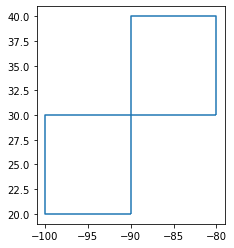

In [4]:
data = obj.get()['Body']
df_delta_tiles = gpd.read_file(data)
df_delta_tiles.exterior.plot()

In [5]:
df_delta_tiles

,bucket,key,source_url,year,geometry
0,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-90.00000 20.00000, -90.00000 30.000..."
1,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-80.00000 30.00000, -80.00000 40.000..."


In [6]:
records = df_delta_tiles.to_dict('records')

# Read Data with Rasterio (Example)

It's negligible on a fast server.

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

In [7]:
record = records[0]

The initial reference for below this [issue ticket](https://github.com/rasterio/rasterio/issues/1507) and [this](https://rasterio.readthedocs.io/en/latest/topics/memory-files.html) in-memory example) docs page.

Below downloading and reading takes about a 1.25 minutes (the downloading into RAM takes ~40 seconds). Again, there are two parts to the below (downloading into bytes and then loading into rasterio/gdal). We still use multithreading, but this may not be desirable for applications.

In [8]:
%%time

bucket = record['bucket']
key = record['key']

obj = s3.Object(bucket, key)
resp = obj.get()

total_size = resp['ContentLength']
config = TransferConfig(multipart_threshold=1024, 
                        max_concurrency=30, 
                        use_threads=True)
with tqdm(total=total_size,  
          unit='B', 
          unit_scale=True, 
          unit_divisor=1024) as pbar:
    with tempfile.NamedTemporaryFile() as tmpfile:
        s3.meta.client.download_fileobj(bucket, key, tmpfile, Config=config, Callback=pbar.update)
        
        with rasterio.open(tmpfile.name) as ds:
            img_hansen = ds.read()
            profile = ds.profile
profile

100%|████████████████████████████████████████████████| 4.68G/4.68G [00:51<00:00, 97.9MB/s]

CPU times: user 48.1 s, sys: 30.1 s, total: 1min 18s
Wall time: 51.6 s


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -100.0,
       0.0, -0.00025, 30.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

Note on these servers (if the data is localized - reading the data takes about 26.7 seconds); however, on s3 it takes a bit longer as above.

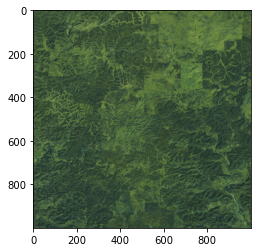

In [9]:
plt.imshow(img_hansen.transpose([1, 2, 0])[:1_000, :1_000, [3, 2, 1]])

# Cropping Example

So, we ran out of memory applying to 40k x 40k image. I don't want to go into dask, so we are going to just have our reference maps to be arbitrary subsets of the hansen image.

<AxesSubplot:>

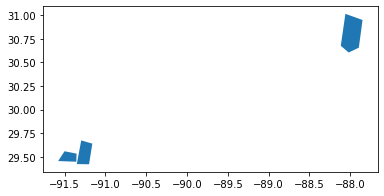

In [10]:
df_aoi = gpd.read_file('aois.geojson')
df_aoi.plot()

In [11]:
aoi_geo = df_aoi.geometry.unary_union.buffer(.1)
geo_int = df_delta_tiles.geometry.intersection(aoi_geo)

df_delta_tiles_updated = df_delta_tiles.copy()
df_delta_tiles_updated.geometry = geo_int.envelope

<AxesSubplot:>

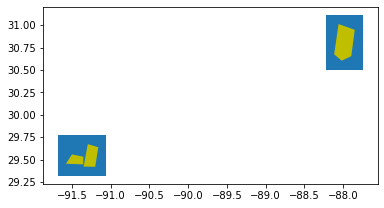

In [12]:
fig, ax= plt.subplots()

df_delta_tiles_updated.plot(ax = ax)
df_aoi.plot(ax=ax, color='y')

In [13]:
df_delta_tiles_updated.geometry[0].bounds

(-91.678270890115, 29.320518966016902, -91.06014651033061, 29.77309292820278)

In [14]:
df_delta_tiles_updated

,bucket,key,source_url,year,geometry
0,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320..."
1,test-prod--hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-88.21591 30.50389, -87.74982 30.503..."


In [15]:
from rasterio.transform import rowcol

def get_rowcol(row):
    with rasterio.Env(AWSSession(session)):
        bucket = row['bucket']
        key = row['key']
        with rasterio.open(f's3://{bucket}/{key}') as ds:
            transform = ds.transform
    xmin, ymin, xmax, ymax = row['geometry'].bounds
    row, col = rowcol(transform, 
                      [xmin, xmax], 
                      [ymax, ymin])
    
    return {'ind_x': np.s_[col[0]: col[1]],
            'ind_y': np.s_[row[0]: row[1]]}


indices = df_delta_tiles_updated.agg(get_rowcol, axis=1).tolist()
indices

[{'ind_x': slice(33286, 35759, None), 'ind_y': slice(907, 2717, None)},
 {'ind_x': slice(7136, 9000, None), 'ind_y': slice(35548, 37984, None)}]

We have to convert BIL gdal formatted array to BSQ numpy formatted arrays using `transpose`. Here is a reference for this terminology: http://idlcoyote.com/ip_tips/where3.html.

In [16]:
# selected to approximately contain AOIs - not precise
k = 0
ind = indices[k]
y_ind = ind['ind_y']
x_ind = ind['ind_x']

img_hansen_c = img_hansen.transpose([1, 2, 0])[y_ind, x_ind, :]
profile_class = get_cropped_profile(profile, x_ind, y_ind)

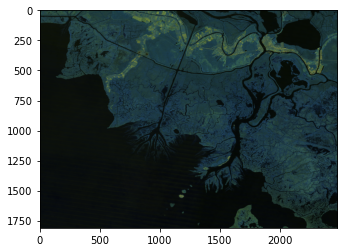

In [17]:
plt.imshow(img_hansen_c[:, :, [3, 2, 1]])

# Uploading a New Cropped Dataset

## The Index

This is the dataframe from above. We will leave the name of the file the same and update the bucket name.

In [18]:
df_delta_tiles_updated['bucket'] = 'test-prod--cropped-hansen-landsat-mosaics-2020'
df_delta_tiles_updated

,bucket,key,source_url,year,geometry
0,test-prod--cropped-hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320..."
1,test-prod--cropped-hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-88.21591 30.50389, -87.74982 30.503..."


Let's create the bucket.

In [19]:
bucket_name = df_delta_tiles_updated.bucket[0]
buckets = list(s3.buckets.all())
if bucket_name not in [b.name for b in buckets]:
    s3.Bucket(bucket_name).create(CreateBucketConfiguration={'LocationConstraint': 'us-west-2'})

In [20]:
geojson_bytes = bytes(df_delta_tiles_updated.to_json(drop_id=True).encode('UTF-8'))
geojson_bytes

b'{"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {"bucket": "test-prod--cropped-hansen-landsat-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_30N_100W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-91.678270890115, 29.320518966016902], [-91.06014651033061, 29.320518966016902], [-91.06014651033061, 29.77309292820278], [-91.678270890115, 29.77309292820278], [-91.678270890115, 29.320518966016902]]]}}, {"type": "Feature", "properties": {"bucket": "test-prod--cropped-hansen-landsat-mosaics-2020", "key": "Hansen_GFC-2020-v1.8_last_40N_090W.tif", "source_url": "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif", "year": 2020}, "geometry": {"type": "Polygon", "coordinates": [[[-88.21591391901751, 30.503890401521048], [-87.74982410210579, 30.50389040152

In [21]:
geojson_bucket = 'calval-metadata'
geojson_key = f'{df_delta_tiles_updated.bucket[0]}.geojson'

s3object = s3.Object(geojson_bucket, geojson_key)
s3object.put(Body=geojson_bytes)

{'ResponseMetadata': {'RequestId': 'M80ATD2DP4BXFEYJ',
  'HostId': 'mZvl7dE2C4j8bEyPRhBBdPUWeE8A5XXv3oU0IoP2G367fD4+gAIQbRZFhBAf/K88rlH+7GrICvA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'mZvl7dE2C4j8bEyPRhBBdPUWeE8A5XXv3oU0IoP2G367fD4+gAIQbRZFhBAf/K88rlH+7GrICvA=',
   'x-amz-request-id': 'M80ATD2DP4BXFEYJ',
   'date': 'Wed, 29 Dec 2021 19:11:09 GMT',
   'etag': '"9ddaa0f0935cbe8479d4216a0b156929"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"9ddaa0f0935cbe8479d4216a0b156929"'}

## The Cropped Images

In [22]:
old_records = df_delta_tiles.to_dict('records')
old_records

[{'bucket': 'test-prod--hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f606b058b80>},
 {'bucket': 'test-prod--hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f606b058220>}]

In [23]:
new_records = df_delta_tiles_updated.to_dict('records')
new_records

[{'bucket': 'test-prod--cropped-hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f606b0585e0>},
 {'bucket': 'test-prod--cropped-hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f60601e1870>}]

Used this [thread](https://github.com/rasterio/rasterio/issues/1159#issuecomment-532027616); sure there are lots of alternatives. Just trying to use the above.

In [24]:
from rasterio.io import MemoryFile

def retrieve_image(record):
    bucket = record['bucket']
    key = record['key']

    obj = s3.Object(bucket, key)
    resp = obj.get()

    total_size = resp['ContentLength']
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30, 
                            use_threads=True)
    with tqdm(total=total_size,  
              unit='B', 
              unit_scale=True, 
              unit_divisor=1024,
              desc=f'download {key}') as pbar:
        with tempfile.NamedTemporaryFile() as tmpfile:
            s3.meta.client.download_fileobj(bucket, key, tmpfile, Config=config, Callback=pbar.update)

            with rasterio.open(tmpfile.name) as ds:
                image = ds.read()
                profile = ds.profile
    return image, profile


def crop_image(img, img_profile, cropped_bounds):
    xmin, ymin, xmax, ymax = cropped_bounds
    row, col = rowcol(img_profile['transform'], 
                      [xmin, xmax], 
                      [ymax, ymin])
    
    ind_x = np.s_[col[0]: col[1]]
    ind_y = np.s_[row[0]: row[1]]
    
    profile_c = get_cropped_profile(img_profile, ind_x, ind_y)
    return img[:, ind_y, ind_x], profile_c
    
def crop_and_upload_one(old_record, new_record):
    
    img, profile = retrieve_image(old_record)
    
    new_s3_bucket = new_record['bucket']
    new_s3_key = new_record['key']
    cropped_bounds = new_record['geometry'].bounds
    
    img_c, profile_c = crop_image(img, profile, cropped_bounds)
    
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30,
                            # Commenting this out appears to make upload speed more variable
                            #multipart_chunksize=1024, 
                            use_threads=True)


    bucket = s3.Bucket(new_s3_bucket)
    with MemoryFile() as mem_file:
        with mem_file.open(**profile_c) as dataset:
            dataset.write(img_c)
            
        # memfile has nbytes for total size
        # must be closed for correct viewing
        # source: https://github.com/rasterio/rasterio/blob/master/tests/test_memoryfile.py#L148-L151
        view = mem_file.getbuffer()
        total_size = view.size
        with tqdm(total=total_size,  
                  unit='B', 
                  unit_scale=True, 
                  unit_divisor=1024,
                  desc=f'upload {new_s3_key}') as pbar:
                
            # memfile must be closed before writing otherwise will be "incorrect file format"
            bucket.upload_fileobj(mem_file, new_s3_key, Config=config, Callback=pbar.update)
    
    return f'{new_s3_bucket}/{new_s3_key}'

In [25]:
from itertools import starmap

list(starmap(crop_and_upload_one, zip(old_records, new_records)))

download Hansen_GFC-2020-v1.8_last_30N_100W.tif: 100%|█| 4.68G/4.68G [00:51<00:00, 98.4MB/
upload Hansen_GFC-2020-v1.8_last_30N_100W.tif: 100%|█| 10.4M/10.4M [00:00<00:00, 11.3MB/s]
download Hansen_GFC-2020-v1.8_last_40N_090W.tif: 100%|█| 12.3G/12.3G [01:47<00:00, 123MB/s
upload Hansen_GFC-2020-v1.8_last_40N_090W.tif: 100%|█| 13.0M/13.0M [00:01<00:00, 13.6MB/s]


['test-prod--cropped-hansen-landsat-mosaics-2020/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
 'test-prod--cropped-hansen-landsat-mosaics-2020/Hansen_GFC-2020-v1.8_last_40N_090W.tif']

# Notes

Although this is somewhat automated, we note with more global AOIs, some adjustments would have to be made. Specifically, say AOIs were at opposite corners of a tile, we would still want some cropping. Likely, we would want to look through `Polygons` of a `MultiPolygon` in shapely-speak. However, this provides some indication about how to deal with this data.